In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time  # Per misurare il tempo di esecuzione di ogni grid search
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # Necessario per abilitare IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from imblearn.over_sampling import SMOTE

# Import dei classificatori
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --- Project Constants ---
PKL_PATH = "../data/interim/"
INPUT_PKL_FILENAME = "preprocessed.pkl"

TARGET_VARIABLE = 'decision'
SEED = 37  # For reproducibility

df = pd.read_pickle(PKL_PATH + INPUT_PKL_FILENAME)

In [37]:
X = df.drop(columns=[TARGET_VARIABLE])      # RICORDA: non sono vere copie indipendenti del DataFrame
y = df[TARGET_VARIABLE]

categorical_columns = ['race', 'race_o', 'field']
binary_text_columns = ['gender']
binary_numeric_columns = ['samerace']
numeric_columns = [
    col for col in X.select_dtypes(include=['int64', 'float64']).columns
    if col not in binary_numeric_columns
]

assert len(categorical_columns) + len(binary_text_columns) + len(binary_numeric_columns) + len(numeric_columns) == len(df.columns) - 1

In [38]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y)

In [39]:
# 3. Ora, CALCOLA scale_pos_weight SOLO SU y_train
# Supponiamo che la classe negativa sia 0 e la positiva sia 1
# y_train è una Series di pandas
counts = y_train.value_counts()
count_negative = counts[0]  # Numero di campioni con etichetta 0
count_positive = counts[1]  # Numero di campioni con etichetta 1

# La formula standard e più comune per calcolare scale_pos_weight è:
# scale_pos_weight = Numero di esempi della classe negativa / Numero di esempi della classe positiva

if count_positive > 0:
    scale_pos_weight_value = count_negative / count_positive
else:
    # Gestisci il caso in cui non ci sono esempi positivi nel training set (improbabile con stratify)
    scale_pos_weight_value = 1 

print(f"Rapporto Negativi/Positivi nel training set: {scale_pos_weight_value:.2f}")

Rapporto Negativi/Positivi nel training set: 1.37


In [40]:
# --- Pipeline per le colonne NUMERICHE STANDARD ---
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(
        estimator=BayesianRidge(), 
        max_iter=20, 
        random_state=SEED
    )),
    ('scaler', RobustScaler())
])

# --- Pipeline per le colonne CATEGORICHE ---
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# --- Pipeline per le colonne BINARIE ---
# Creiamo un trasformatore personalizzato per mappare 'gender'
class GenderMapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Usiamo .loc per evitare SettingWithCopyWarning
        X_copy = X.copy()
        gender_map = {'female': 0, 'male': 1}
        # Applichiamo la mappa. I NaN rimangono NaN.
        X_copy['gender'] = X_copy['gender'].map(gender_map)
        return X_copy

# Ora la Pipeline per 'gender'
binary_text_transformer = Pipeline(steps=[
    ('mapper', GenderMapper()), # Mappa 'female'/'male' a 0/1
    ('imputer', SimpleImputer(strategy='most_frequent')) # Imputa i NaN con la moda (0 o 1)
])

# Pipeline per 'samerace' (che è già quasi a posto)
binary_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


# 3. Combinazione di TUTTO con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('bin_text', binary_text_transformer, binary_text_columns),
        ('bin_num', binary_numeric_transformer, binary_numeric_columns)
    ],
    remainder='drop'
)

In [41]:
estimators = {
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=SEED),
    'xgboost': XGBClassifier(random_state=SEED, eval_metric='logloss'),
    'catboost': CatBoostClassifier(random_state=SEED, verbose=0, allow_writing_files=False),
    'random_forest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
}

param_grids = {
    'hist_gradient_boosting': {
        'model__learning_rate': [0.03, 0.05],
        'model__max_depth': [7],
        'model__class_weight': ['balanced'],
        'model__max_iter': [180, 220],
        'model__l2_regularization': [1.0, 1.5]
    },
    # --> Combinazioni totali: 2 * 1 * 1 * 2 * 2 = 8 Combinazioni

    'xgboost': {
        'model__learning_rate': [0.05],
        'model__max_depth': [5],
        'model__scale_pos_weight': [scale_pos_weight_value],
        'model__subsample': [0.8],
        'model__n_estimators': [200, 220],
        'model__gamma': [1.0, 1.5],
        'model__colsample_bytree': [0.8, 1.0] 
    },
    # --> Combinazioni totali: 1 * 1 * 1 * 1 * 2 * 2 * 2 = 8 Combinazioni

    'catboost': {
        'model__learning_rate': [0.05],
        'model__depth': [6],
        'model__scale_pos_weight': [scale_pos_weight_value],
        'model__subsample': [0.8],
        'model__iterations': [280, 300, 320, 340],
        'model__l2_leaf_reg': [5, 6],
        'model__random_strength': [1.0]
    },
    # --> Combinazioni totali: 1 * 1 * 1 * 1 * 4 * 2 * 1 = 8

    'random_forest': {
        'model__n_estimators': [200, 250],
        'model__max_depth': [9, 10],
        'model__min_samples_leaf': [3, 5],
        'model__min_samples_split': [10],
        'model__max_features': [0.7],
        'model__criterion': ['entropy'],
        'model__class_weight': ['balanced_subsample']
    }
    # --> Combinazioni totali: 2 * 2 * 2 * 1 * 1 * 1 = 8 Combinazioni
}

In [42]:
# Definiamo le metriche di scoring
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Decidiamo su quale metrica fare il refit
refit_metric = 'f1'

### Model Training and Hyperparameter Optimization

In [43]:
# Dizionari per salvare i risultati finali
results = {}
best_estimators = {}    # dizionario che conterrà i migliori stimatori per ogni modello, già addestrati e pronti per essere usati.
all_cv_results = {}

for name, model in estimators.items():
    model_title = name.replace('_', ' ').title()
    print(f"\n--- Esecuzione GridSearchCV per: {model_title} ---")
    start_time = time.time()

    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Definiamo la GridSearchCV con le metriche multiple
    grid_search = GridSearchCV(
        estimator = full_pipeline,
        param_grid = param_grids[name],
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED),
        scoring = scoring_metrics,
        refit = refit_metric,
        n_jobs = -1,
        verbose = 5,
        return_train_score=True # Fondamentale per avere gli score di train
    )

    grid_search.fit(X_train, y_train)
    end_time = time.time()
    execution_time = (end_time - start_time) / 60

    # Salvataggio dei risultati principali
    results[name] = {
        'best_score_cv': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'execution_time_minutes': execution_time
    }
    best_estimators[name] = grid_search.best_estimator_
    all_cv_results[name] = pd.DataFrame(grid_search.cv_results_)
    
    print(f"Miglior F1-score (CV) per {model_title}: {grid_search.best_score_:.4f}")
    print(f"Tempo di esecuzione: {execution_time:.2f} minuti")

    # ---------------------------------------------------------------------
    # --- Visualizzazione Dettagliata per il Modello Corrente ---
    # ---------------------------------------------------------------------
    print(f"\n--- Dettaglio Risultati GridSearchCV per {model_title} ---\n")
    
    # Estraiamo i risultati
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Definiamo le colonne che ci interessano
    param_columns = [f'param_{key}' for key in param_grids[name].keys()]
    
    # RICORDA: quando qui si parla di test e train set, si intendono sempre quelli interni alla CV
    score_columns = [
        'mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc',
        'mean_train_accuracy', 'mean_train_f1', 'mean_train_roc_auc',
        f'rank_test_{refit_metric}', 'rank_test_accuracy'
    ]
    
    # Creiamo la tabella da visualizzare
    columns_to_show =  score_columns + param_columns
    model_results_table = cv_results_df[columns_to_show].copy()
    model_results_table.rename(columns=lambda x: x.replace('param_model__', '').replace('param_sampler__', 'smote_'), inplace=True)
    model_results_table.sort_values(by=f'rank_test_{refit_metric}', inplace=True)
    
    # Mostriamo la tabella
    display(model_results_table.head(5))
    print("-" * 80)
    # ---------------------------------------------------------------------




--- Esecuzione GridSearchCV per: Hist Gradient Boosting ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Miglior F1-score (CV) per Hist Gradient Boosting: 0.6495
Tempo di esecuzione: 1.02 minuti

--- Dettaglio Risultati GridSearchCV per Hist Gradient Boosting ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_f1,rank_test_accuracy,learning_rate,max_depth,class_weight,max_iter,l2_regularization
3,0.698992,0.649549,0.763789,0.888329,0.871633,0.959142,1,2,0.05,7,balanced,220,1.0
5,0.695727,0.648818,0.757823,0.841474,0.819003,0.925030,2,5,0.03,7,balanced,220,1.5
2,0.696295,0.648560,0.762466,0.869409,0.850414,0.946458,3,4,0.05,7,balanced,180,1.0
6,0.698139,0.648550,0.763325,0.868096,0.848908,0.944413,4,3,0.05,7,balanced,180,1.5
7,0.699416,0.648547,0.764456,0.886625,0.869708,0.957767,5,1,0.05,7,balanced,220,1.5


--------------------------------------------------------------------------------

--- Esecuzione GridSearchCV per: Xgboost ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Miglior F1-score (CV) per Xgboost: 0.6523
Tempo di esecuzione: 0.79 minuti

--- Dettaglio Risultati GridSearchCV per Xgboost ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_f1,rank_test_accuracy,learning_rate,max_depth,scale_pos_weight,subsample,n_estimators,gamma,colsample_bytree
0,0.700127,0.652256,0.761452,0.851200,0.829079,0.931725,1,2,0.05,5,1.374579,0.8,200,1.0,0.8
3,0.700268,0.651496,0.762514,0.858228,0.836911,0.937814,2,1,0.05,5,1.374579,0.8,220,1.5,0.8
2,0.698847,0.650842,0.761062,0.849105,0.826722,0.930773,3,4,0.05,5,1.374579,0.8,200,1.5,0.8
1,0.697286,0.650399,0.762548,0.860819,0.840205,0.938923,4,8,0.05,5,1.374579,0.8,220,1.0,0.8
5,0.699131,0.650000,0.760915,0.866250,0.846620,0.942826,5,3,0.05,5,1.374579,0.8,220,1.0,1.0


--------------------------------------------------------------------------------

--- Esecuzione GridSearchCV per: Catboost ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Miglior F1-score (CV) per Catboost: 0.6529
Tempo di esecuzione: 1.02 minuti

--- Dettaglio Risultati GridSearchCV per Catboost ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_f1,rank_test_accuracy,learning_rate,depth,scale_pos_weight,subsample,iterations,l2_leaf_reg,random_strength
5,0.700409,0.652872,0.765720,0.853578,0.832077,0.934821,1,1,0.05,6,1.374579,0.8,320,6,1.0
7,0.699984,0.652464,0.767008,0.860926,0.840303,0.940521,2,2,0.05,6,1.374579,0.8,340,6,1.0
3,0.697854,0.650170,0.764962,0.845378,0.822802,0.928770,3,4,0.05,6,1.374579,0.8,300,6,1.0
6,0.698278,0.648766,0.764036,0.864724,0.844963,0.942640,4,3,0.05,6,1.374579,0.8,340,5,1.0
1,0.695298,0.647491,0.763352,0.837747,0.814530,0.922145,5,5,0.05,6,1.374579,0.8,280,6,1.0


--------------------------------------------------------------------------------

--- Esecuzione GridSearchCV per: Random Forest ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Miglior F1-score (CV) per Random Forest: 0.6263
Tempo di esecuzione: 1.87 minuti

--- Dettaglio Risultati GridSearchCV per Random Forest ---



,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,mean_train_accuracy,mean_train_f1,mean_train_roc_auc,rank_test_f1,rank_test_accuracy,n_estimators,max_depth,min_samples_leaf,min_samples_split,max_features,criterion,class_weight
7,0.685075,0.626328,0.745228,0.869587,0.848229,0.948490,1,1,250,10,5,10,0.7,entropy,balanced_subsample
6,0.684650,0.626316,0.745101,0.869374,0.848082,0.948252,2,4,200,10,5,10,0.7,entropy,balanced_subsample
1,0.680390,0.626079,0.740625,0.844314,0.820257,0.930142,3,5,250,9,3,10,0.7,entropy,balanced_subsample
3,0.680106,0.625926,0.740988,0.841119,0.816401,0.925848,4,6,250,9,5,10,0.7,entropy,balanced_subsample
2,0.678687,0.625264,0.740705,0.840090,0.815273,0.925400,5,8,200,9,5,10,0.7,entropy,balanced_subsample


--------------------------------------------------------------------------------


### Riepilogo e Confronto dei Modelli

In [44]:
# --- 4. Analisi e Confronto Finale (Versione Migliorata) ---
print("\n\n--- Riepilogo e Confronto dei Modelli (con Analisi Overfitting e Parametri) ---")

# Lista per contenere i dati di riepilogo per ogni modello
summary_data = []

# Iteriamo sui DataFrame dei risultati della CV che hai salvato in all_cv_results
for name, cv_results_df in all_cv_results.items():
    
    # Troviamo l'indice della riga con il miglior modello (quello scelto da refit='f1')
    best_model_index = cv_results_df[f'rank_test_{refit_metric}'].idxmin()
    
    # Estraiamo l'intera riga (che è una Series) contenente tutti i dati di quel modello
    best_result_series = cv_results_df.loc[best_model_index]
    
    # --- NUOVA AGGIUNTA 1: Calcoliamo il gap F1 come indice di overfitting ---
    # Un gap più piccolo è migliore (indica una buona generalizzazione)
    train_f1 = best_result_series['mean_train_f1']
    test_f1 = best_result_series['mean_test_f1']
    overfitting_gap_f1 = train_f1 - test_f1

    # --- NUOVA AGGIUNTA 2: Recuperiamo i parametri migliori dal dizionario 'results' ---
    # Questo ci mostra la combinazione vincente di parametri del modello E di SMOTE
    best_params = results[name]['best_params']
    
    # Aggiungiamo un dizionario con le informazioni che ci interessano alla nostra lista
    summary_data.append({
        'model': name.replace('_', ' ').title(),
        # Metriche principali (le più importanti prima)
        'mean_test_f1': test_f1,
        'mean_train_f1': train_f1,
        'f1_gap_(train-test)': overfitting_gap_f1, # Nuova colonna!
        'mean_test_roc_auc': best_result_series['mean_test_roc_auc'],
        'mean_test_accuracy': best_result_series['mean_test_accuracy'],
        # Informazioni aggiuntive
        'execution_time_minutes': results[name]['execution_time_minutes'],
        'best_params': best_params # Nuova colonna!
    })

# Creiamo il DataFrame di confronto finale
comparison_df = pd.DataFrame(summary_data)
comparison_df.set_index('model', inplace=True)

# Ordiniamo la tabella in base alla metrica più importante (F1 medio della CV)
comparison_df = comparison_df.sort_values(by='mean_test_f1', ascending=False)

# Applichiamo una formattazione per una migliore leggibilità
# Selezioniamo tutte le colonne numeriche tranne i parametri
float_cols = [col for col in comparison_df.columns if 'time' not in col and 'params' not in col]

# Formattiamo le colonne degli score a 4 cifre decimali
for col in float_cols:
    comparison_df[col] = comparison_df[col].map('{:.4f}'.format)

# Formattiamo la colonna del tempo a 2 cifre decimali
comparison_df['execution_time_minutes'] = comparison_df['execution_time_minutes'].map('{:.2f}'.format)

# Mostriamo la tabella di confronto finale
print("Tabella di confronto dei modelli ordinata per F1-score (CV):")
display(comparison_df)



--- Riepilogo e Confronto dei Modelli (con Analisi Overfitting e Parametri) ---
Tabella di confronto dei modelli ordinata per F1-score (CV):


,mean_test_f1,mean_train_f1,f1_gap_(train-test),mean_test_roc_auc,mean_test_accuracy,execution_time_minutes,best_params
model,,,,,,,
Catboost,0.6529,0.8321,0.1792,0.7657,0.7004,1.02,"{'model__depth': 6, 'model__iterations': 320, ..."
Xgboost,0.6523,0.8291,0.1768,0.7615,0.7001,0.79,"{'model__colsample_bytree': 0.8, 'model__gamma..."
Hist Gradient Boosting,0.6495,0.8716,0.2221,0.7638,0.6990,1.02,"{'model__class_weight': 'balanced', 'model__l2..."
Random Forest,0.6263,0.8482,0.2219,0.7452,0.6851,1.87,"{'model__class_weight': 'balanced_subsample', ..."


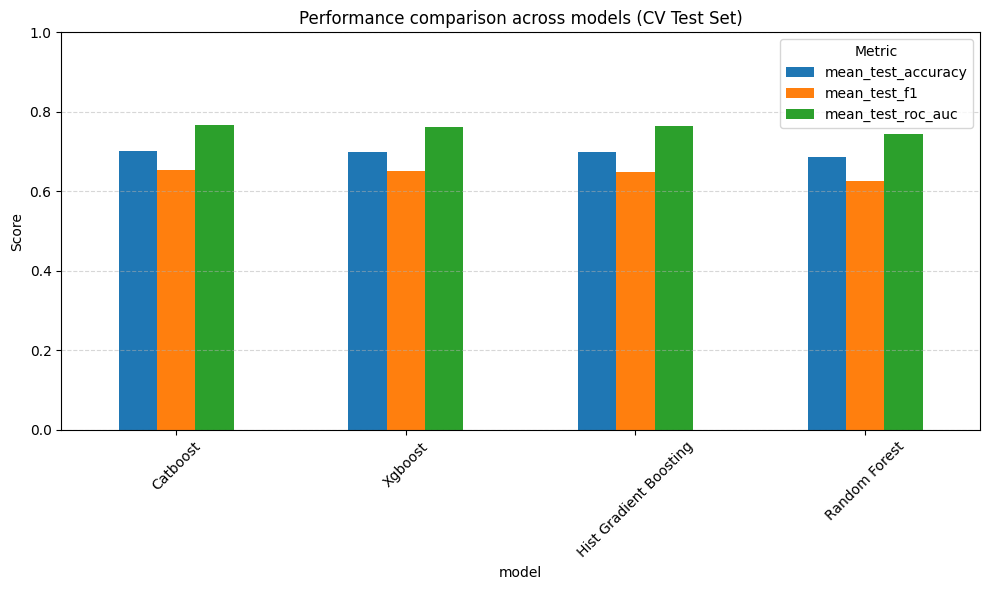

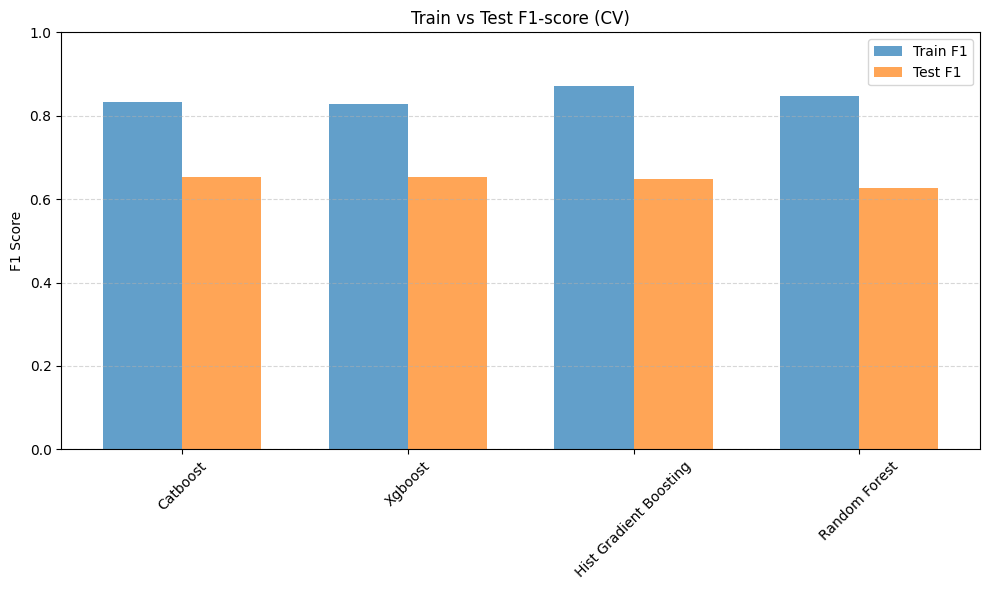

In [45]:
# Copia del DataFrame per lavorare con valori numerici (prima della formattazione)
comparison_numeric = comparison_df.copy()
for col in comparison_numeric.columns:
    comparison_numeric[col] = pd.to_numeric(comparison_numeric[col], errors='coerce')

# === 1. Confronto metriche di test: Accuracy, F1, ROC AUC ===
metrics_to_plot = ['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']

comparison_numeric[metrics_to_plot].plot(kind='bar', figsize=(10, 6))
plt.title('Performance comparison across models (CV Test Set)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# === 2. Confronto Train vs Test per F1 ===
plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = range(len(comparison_numeric))

plt.bar(indices, comparison_numeric['mean_train_f1'], width=bar_width, label='Train F1', alpha=0.7)
plt.bar([i + bar_width for i in indices], comparison_numeric['mean_test_f1'], width=bar_width, label='Test F1', alpha=0.7)

plt.title('Train vs Test F1-score (CV)')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks([i + bar_width / 2 for i in indices], comparison_numeric.index, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Valutazione del Modello Migliore sul Test Set - DA AGGIUSTARE POST RICEVIMENTO


--- Valutazione Finale del Miglior Modello in Assoluto: Catboost ---
Iperparametri scelti: {'model__depth': 6, 'model__iterations': 320, 'model__l2_leaf_reg': 6, 'model__learning_rate': 0.05, 'model__random_strength': 1.0, 'model__scale_pos_weight': np.float64(1.3745785569790965), 'model__subsample': 0.8}

Classification Report sul Test Set:
              precision    recall  f1-score   support

No Match (0)       0.75      0.72      0.73       720
   Match (1)       0.63      0.67      0.65       523

    accuracy                           0.70      1243
   macro avg       0.69      0.70      0.69      1243
weighted avg       0.70      0.70      0.70      1243

--- Metriche Finali sul Test Set ---
F1-Score: 0.6537
ROC-AUC Score: 0.7783
-----------------------------------

Matrice di Confusione del Miglior Modello:


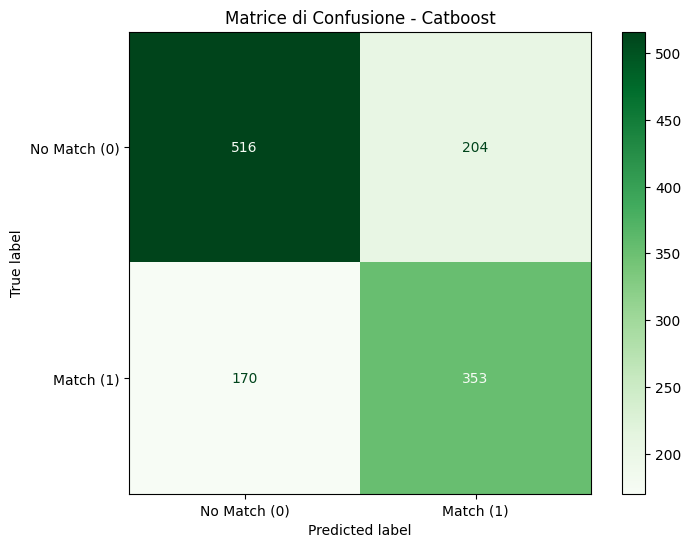

In [46]:
# --- 5. Valutazione del Modello Migliore sul Test Set ---

# Identifichiamo il nome del modello migliore (il primo indice del DataFrame ordinato)
best_model_name_formatted = comparison_df.index[0]
# Convertiamo il nome formattato (es. "Random Forest") nel nome interno usato come chiave (es. "random_forest")
best_model_name_internal = best_model_name_formatted.lower().replace(' ', '_')
best_overall_estimator = best_estimators[best_model_name_internal]

print(f"\n--- Valutazione Finale del Miglior Modello in Assoluto: {best_model_name_formatted} ---")
print(f"Iperparametri scelti: {results[best_model_name_internal]['best_params']}")

# Facciamo le predizioni sul test set
y_pred_test = best_overall_estimator.predict(X_test)
y_proba_test = best_overall_estimator.predict_proba(X_test)[:, 1] # Probabilità per la classe positiva (per ROC-AUC)

# Importiamo le metriche necessarie
from sklearn.metrics import classification_report, f1_score, roc_auc_score, ConfusionMatrixDisplay

# Stampiamo il report di classificazione completo
print("\nClassification Report sul Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['No Match (0)', 'Match (1)']))

# Stampiamo le metriche chiave separatamente per evidenziarle
final_f1 = f1_score(y_test, y_pred_test)
final_roc_auc = roc_auc_score(y_test, y_proba_test)

print("--- Metriche Finali sul Test Set ---")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC Score: {final_roc_auc:.4f}")
print("-" * 35)

# Visualizziamo la matrice di confusione del modello migliore
print("\nMatrice di Confusione del Miglior Modello:")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_overall_estimator,
    X_test,
    y_test,
    ax=ax,
    cmap='Greens', # Cambiamo colore per distinguerla dalle precedenti
    values_format='d',
    display_labels=['No Match (0)', 'Match (1)']
)
ax.set_title(f"Matrice di Confusione - {best_model_name_formatted}")
plt.show()